# Explorartory Data Analysis of Sentiment_Data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Set theme

In [5]:
sns.set_theme(style = 'whitegrid')
plt.rcParams['figure.figsize'] = (12,6)

## Load Dataset

In [6]:
df = pd.read_csv("../data/preprocessed/sentiment_data/sentiment_clean.csv")

In [7]:
df

,timestamp,value,classification,date,sentiment_score
0,2018-02-01 05:30:00+00:00,30,Fear,2018-02-01,25
1,2018-02-02 05:30:00+00:00,15,Extreme Fear,2018-02-02,0
2,2018-02-03 05:30:00+00:00,40,Fear,2018-02-03,25
3,2018-02-04 05:30:00+00:00,24,Extreme Fear,2018-02-04,0
4,2018-02-05 05:30:00+00:00,11,Extreme Fear,2018-02-05,0
...,...,...,...,...,...
2639,2025-04-28 05:30:00+00:00,54,Neutral,2025-04-28,50
2640,2025-04-29 05:30:00+00:00,60,Greed,2025-04-29,75
2641,2025-04-30 05:30:00+00:00,56,Greed,2025-04-30,75
2642,2025-05-01 05:30:00+00:00,53,Neutral,2025-05-01,50


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        2644 non-null   object
 1   value            2644 non-null   int64 
 2   classification   2644 non-null   object
 3   date             2644 non-null   object
 4   sentiment_score  2644 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 103.4+ KB


In [9]:
df.describe()

,value,sentiment_score
count,2644.000000,2644.00000
mean,46.981089,45.15885
std,21.827680,33.16330
min,5.000000,0.00000
25%,28.000000,25.00000
50%,46.000000,50.00000
75%,66.000000,75.00000
max,95.000000,100.00000


In [10]:
print("Missing values:\n", df.isna().sum())
print("Unique classifications:", df['classification'].unique())

Missing values:
 timestamp          0
value              0
classification     0
date               0
sentiment_score    0
dtype: int64
Unique classifications: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


# Distributions

### Distribution of Sentiment Index Value

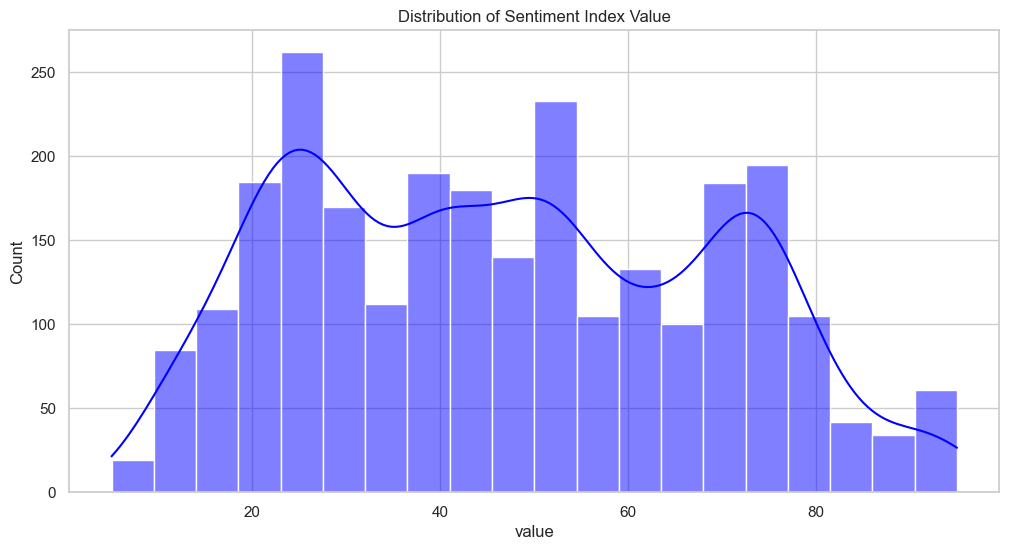

In [11]:
sns.histplot(df['value'], bins = 20, kde = True, color = 'blue')
plt.title("Distribution of Sentiment Index Value")
plt.savefig("../reports/figures/Sentiment/Distribution of Sentiment Index Value.png")
plt.show()

### Frequency of Sentiment Classification

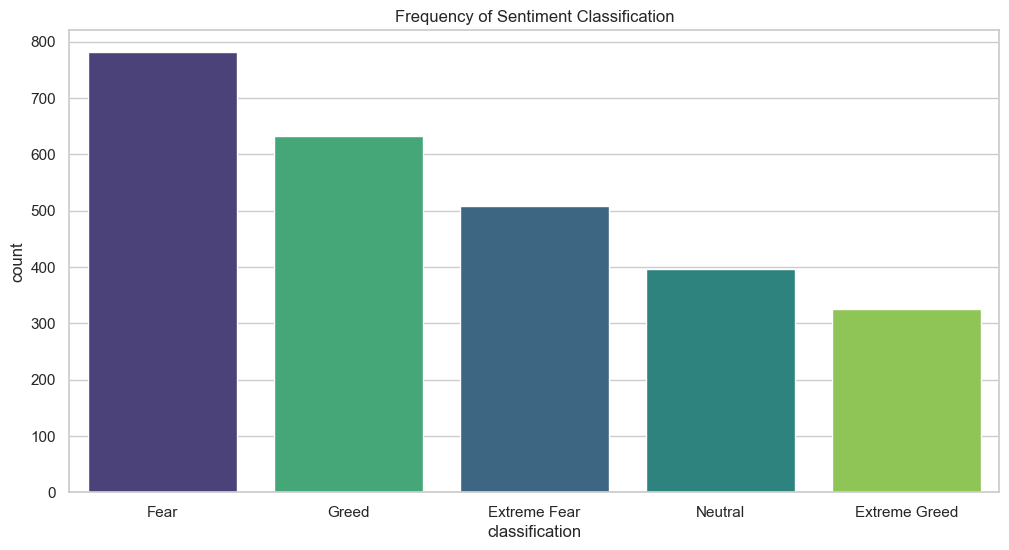

In [15]:
sns.countplot(x = 'classification', data = df, order = df['classification'].value_counts().index, palette = 'viridis', hue = 'classification', legend = False )
plt.title("Frequency of Sentiment Classification")
plt.savefig("../reports/figures/Sentiment/Frequency of Sentiment Classification.png")
plt.show()

# Time Series Trends

### Sentiment Index Over Time

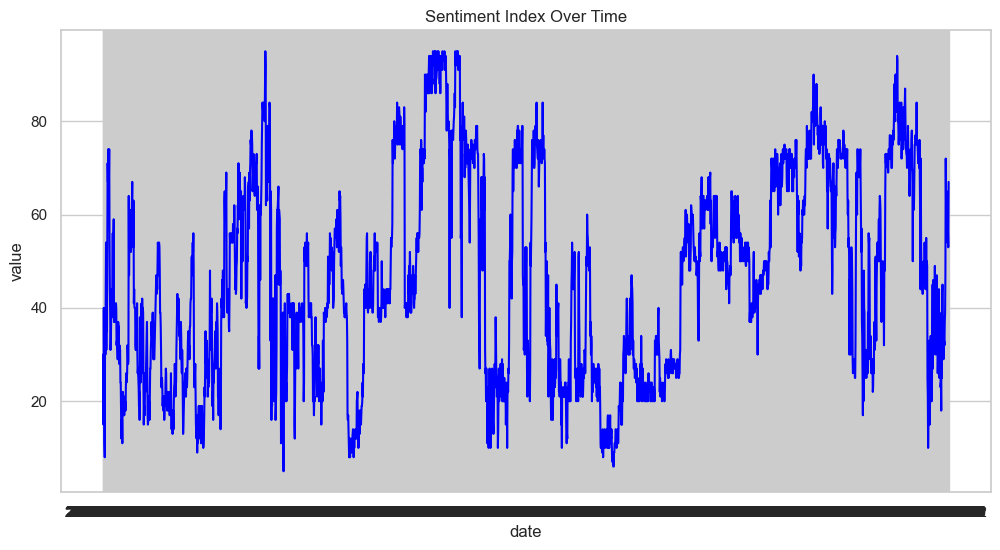

In [17]:
sns.lineplot(data = df, x = 'date', y = 'value', color = 'blue')
plt.title("Sentiment Index Over Time")
plt.savefig("../reports/figures/Sentiment/Sentiment Index Over Time.png")
plt.show()

### Sentiment Index with Rolling Averages

In [19]:
df['value_7d'] = df['value'].rolling(window = 7).mean()
df['value_30d'] = df['value'].rolling(window = 30).mean()

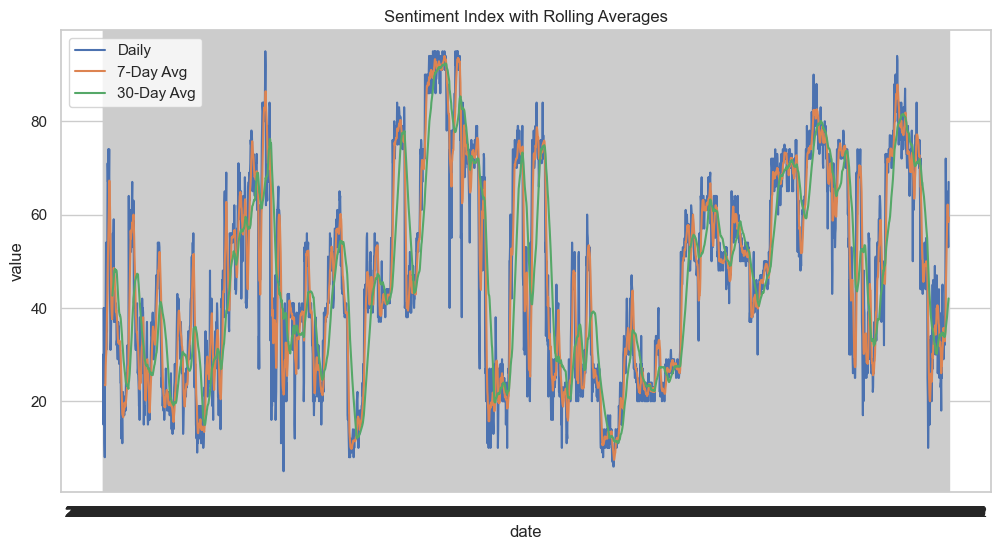

In [20]:
sns.lineplot(data = df, x = 'date', y = 'value', label = 'Daily')
sns.lineplot(data = df, x = 'date', y = 'value_7d', label = '7-Day Avg')
sns.lineplot(data = df, x = 'date', y = 'value_30d', label = '30-Day Avg')
plt.legend()
plt.title("Sentiment Index with Rolling Averages")
plt.savefig('../reports/figures/Sentiment/Sentiment Index with Rolling Averages.png')
plt.show()

# Volatility & Exterme Periods

### 7-Day Rolling Sentiment Volatility

In [21]:
df['daily_change'] = df['value'].diff()
df['volatility_7d'] = df['daily_change'].rolling(7).std()

### 7-Day Rolling Sentiment Volatility

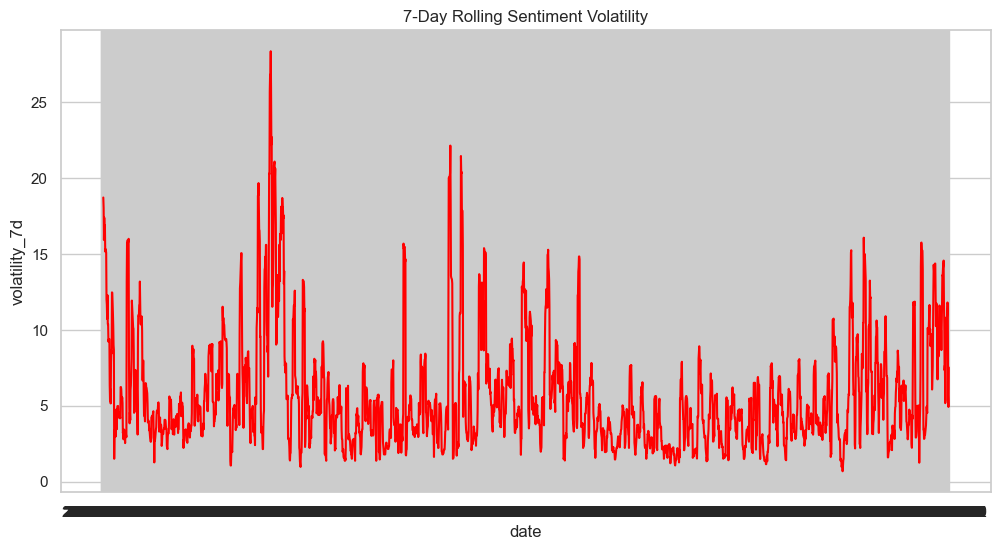

In [22]:
sns.lineplot(data = df, x = 'date', y = 'volatility_7d',color = 'red')
plt.title("7-Day Rolling Sentiment Volatility")
plt.savefig("../reports/figures/Sentiment/7-Day Rolling Sentiment Volatility.png")
plt.show()

### Extreme Fear & Greed Markers

In [23]:
extreme_fear = df[df['classification'] == 'Extreme Fear']
extreme_greed = df[df['classification'] == 'Extreme Greed']

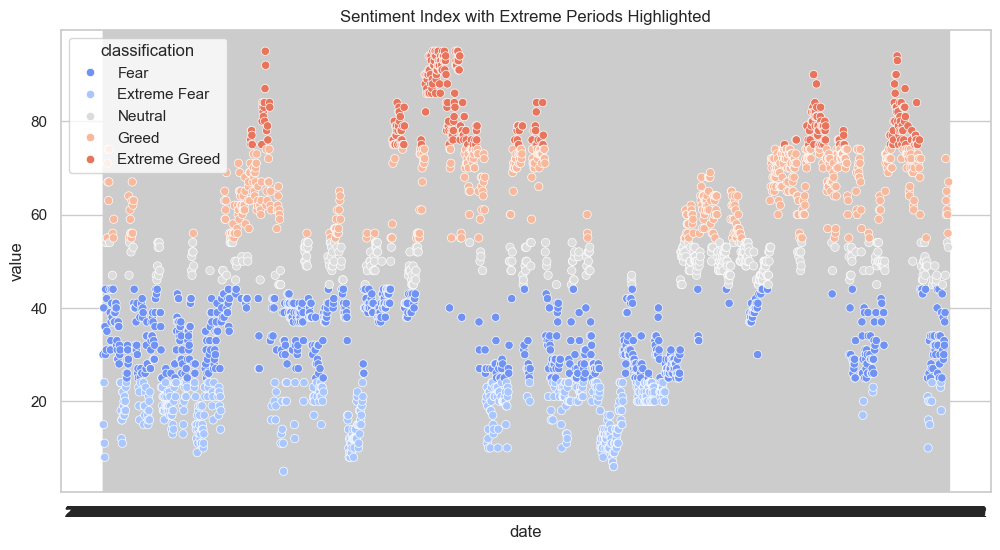

In [26]:
sns.scatterplot(data = df, x = 'date', y = 'value', hue = 'classification', palette = 'coolwarm')
plt.title("Sentiment Index with Extreme Periods Highlighted")
plt.savefig("../reports/figures/Sentiment/Sentiment Index with Extreme Periods Highlighted.png")
plt.show()

# Seasonality & Decomposition

### Daily Time Series

In [31]:
df['date'] = pd.to_datetime(df['date'])

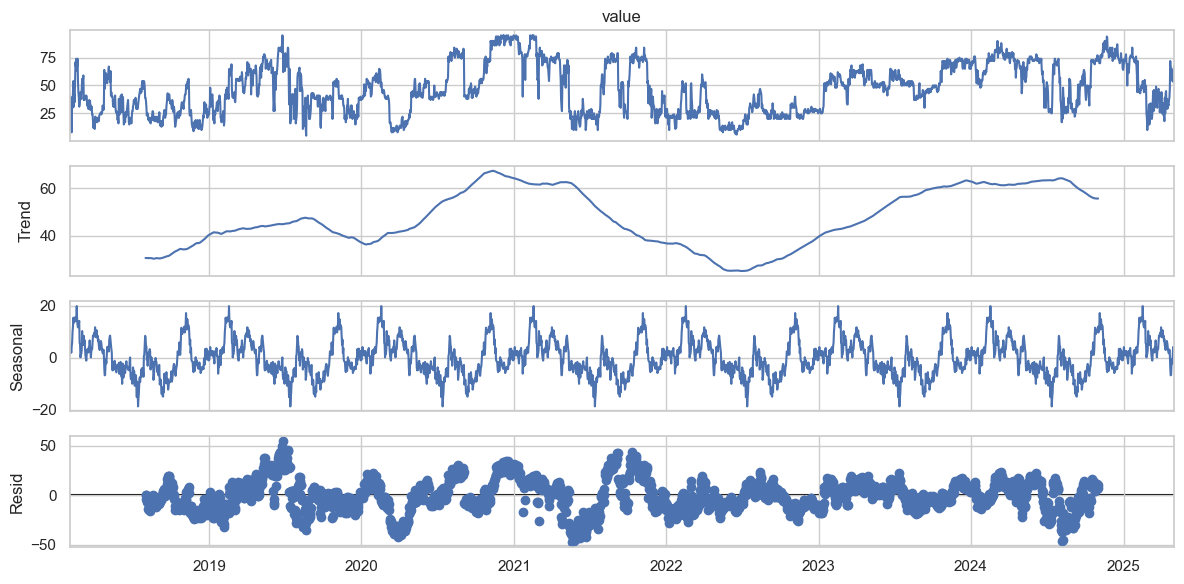

In [32]:
df_ts = df.set_index('date')['value'].asfreq('D').interpolate()
decomp = seasonal_decompose(df_ts, model='additive', period=365)
decomp.plot()
plt.savefig("../reports/figures/Sentiment/Daily Time Series.png")
plt.show()

# Transition Probabilities (Markov Chain)

### Sentiment Transition Probability Matrix

In [35]:
df['next_class'] = df['classification'].shift(-1)
transitions = df.groupby(['classification', 'next_class']).size().reset_index(name = 'count')
transition_matrix = transitions.pivot(index = 'classification', columns = 'next_class', values = 'count').fillna(0)
transition_matrix = transition_matrix.div(transition_matrix.sum(axis = 1), axis = 0)

In [39]:
print("Sentiment Transition Probability Matrix:")
transition_matrix

Sentiment Transition Probability Matrix:


next_class,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
classification,,,,,
Extreme Fear,0.818898,0.000000,0.173228,0.000000,0.007874
Extreme Greed,0.000000,0.831288,0.006135,0.159509,0.003067
Fear,0.112676,0.001280,0.781050,0.015365,0.089629
Greed,0.001582,0.085443,0.018987,0.787975,0.106013
Neutral,0.007576,0.000000,0.171717,0.179293,0.641414


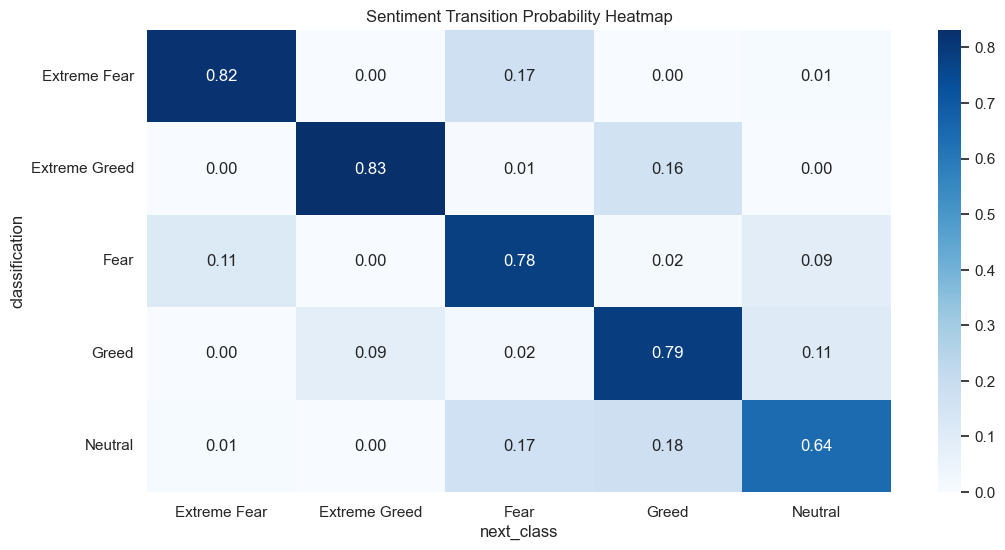

In [ ]:
sns.heatmap(transition_matrix, annot = True, cmap = 'Blues', fmt = ".2f")
plt.title("Sentiment Transition Probability Heatmap")
plt.savefig("../reports/figures/Sentiment/Sentiment Transition Probability Heatmap.png")
plt.show()

# Cycle Detection

In [42]:
peaks, _ = find_peaks(df['value'], distance = 5)
troughts, _ = find_peaks(-df['value'], distance = 5)

### Sentiments Peaks & Troughts

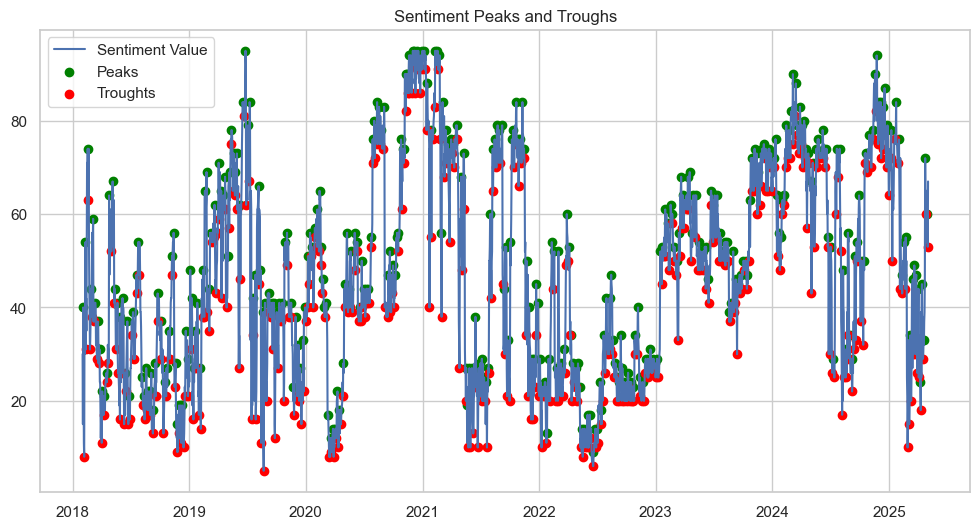

In [43]:
plt.plot(df['date'], df['value'], label = 'Sentiment Value')
plt.scatter(df['date'].iloc[peaks], df['value'].iloc[peaks], color = 'green', label = 'Peaks')
plt.scatter(df['date'].iloc[troughts], df['value'].iloc[troughts], color = 'red', label = 'Troughts')
plt.legend()
plt.title("Sentiment Peaks and Troughs")
plt.savefig("../reports/figures/Sentiment/Sentiment Peaks and Troughs.png")
plt.show()

# Clustering Sentiment Regimes

In [45]:
df_clust = df[['value', 'daily_change', 'volatility_7d']].dropna()
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(df_clust)

In [48]:
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = 10)
df_clust['cluster'] = kmeans.fit_predict(X_Scaled)

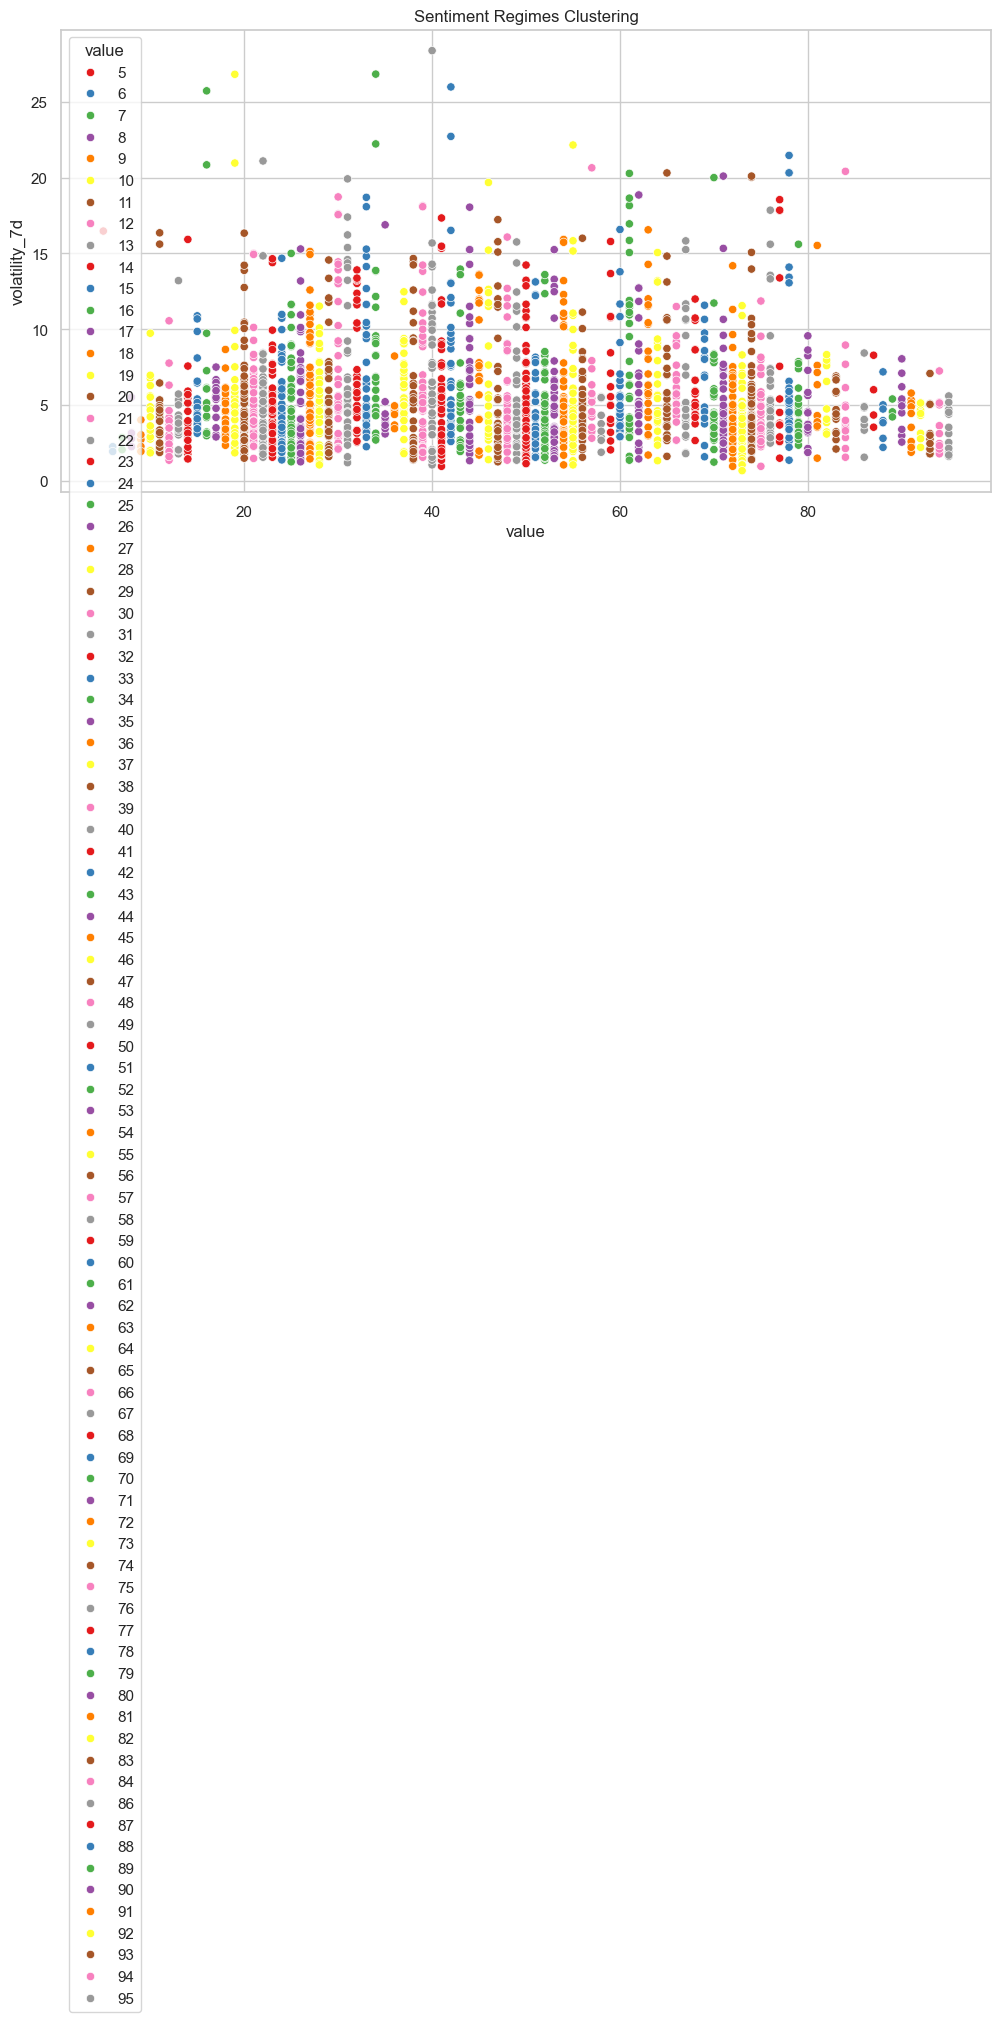

In [50]:
sns.scatterplot(data = df_clust, x = 'value', y = 'volatility_7d', hue = 'value', palette = "Set1")
plt.title("Sentiment Regimes Clustering")
plt.savefig("../reports/figures/Sentiment/Sentiment Regimes Clustering.png")
plt.show()

## Interactive Exploration

In [52]:
fig = px.line(df, x = 'date', y = 'value', color = 'classification', title = 'Interactive Sentiment Index')
fig.write_image("../reports/figures/Sentiment/Interactive Sentiment Index.png")
fig.show()

In [53]:
fig = px.histogram(df, x = 'value', color = 'classification', nbins = 20, title = "Sentiment Distribution by Category")
fig.write_image("../reports/figures/Sentiment/Sentiment Distribution by Category.png")
fig.show()

In [55]:
df.to_csv("../data/Sentiment EDA/sentiment_eda_results.csv", index=False)
transition_matrix.to_csv("../data/Sentiment EDA/sentiment_transition_matrix.csv")
df_clust.to_csv("../data/Sentiment EDA/sentiment_clusters.csv", index=False)